# Human in the Loop 

the module will dive into human-in-the-loop, which builds on memory and allows users to interact with agents.

First we will look into **Streaming**.

Loading the previous example with memory, we will implement streaming of the output.

## Streaming

In [1]:
!pip install -U langgraph
!pip install langgraph-sdk
!pip install langgraph-checkpoint-sqlite
!pip install langsmith
!pip install -U langchain-community
!pip install -U langchain-core

!pip install -U langchain_huggingface
!pip install -U langchain_openai

!pip install -U dotenv

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 119.3/119.3 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 306.7/306.7 kB 23.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 403.7/403.7 kB 26.3 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.92
    Uninstalling langsmith-0.1.92:
      Successfully uninstalled langsmith-0.1.92
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.2.21
    Uninstalling langchain-core-0.2.21:
      Successfully uninstalled langchain-core-0.2.21
  Attempting uninstall: langgraph
    Found existing installation: langgraph 0.1.9
    Uninstalling langgraph-0.1.9:
      Successfully uninstalled langgraph-0.1.9
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following depend

In [2]:
!pip install -U transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.1/44.1 kB 2.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.0/10.0 MB 51.2 MB/s eta 0:00:0000:010:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.0/3.0 MB 45.0 MB/s eta 0:00:00a 0:00:01
  Attempting uninstall: tokenizers
    Found existing installation: tokenizers 0.19.1
    Uninstalling tokenizers-0.19.1:
      Successfully uninstalled tokenizers-0.19.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.42.4
    Uninstalling transformers-4.42.4:
      Successfully uninstalled transformers-4.42.4


In [1]:
!pip install langchain_groq

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 108.9/108.9 kB 7.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 409.3/409.3 kB 25.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 307.0/307.0 kB 20.1 MB/s eta 0:00:00
  Attempting uninstall: langsmith
    Found existing installation: langsmith 0.1.92
    Uninstalling langsmith-0.1.92:
      Successfully uninstalled langsmith-0.1.92
  Attempting uninstall: langchain-core
    Found existing installation: langchain-core 0.2.21
    Uninstalling langchain-core-0.2.21:
      Successfully uninstalled langchain-core-0.2.21
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
langgraph 0.1.9 requires langchain-core<0.3,>=0.2.19, but you have langchain-core 0.3.18 which is incompatible.
langchain-huggingface 0.0.3 requires langchain-core<0.3,>=0.1.52, but you have langchain-core 0.3.18 which is incompa

In [2]:
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from langgraph.graph import MessagesState, START, END, StateGraph
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from typing_extensions import TypedDict, Literal
from langchain_groq import ChatGroq
from langchain_core.messages import RemoveMessage, trim_messages
import json

In [6]:
class State(MessagesState):
    summary: str;

# lets create the generic System Message as well:
sys_msg = SystemMessage('You are an everhelpful assistant trying to assist your human friend. You are polite, thoughtful \
and with great sense of nerdy humour.')

In [3]:
def call_model(state: State):
    summary = state.get('summary', '')
    if summary:
        system_msg = SystemMessage(f'{sys_msg.content}\nSummary of our the conversation thus far:{summary}')
    else:
        system_msg = sys_msg
    result = llm.invoke([system_msg] + state['messages'])
    return {'messages': result}

def summariser(state: State):
    summary = state.get('summary', '')
    if summary:
        summary_message = f'Extend the current summary: {summary} with the conversation thus far.'
    else:
        summary_message = 'Summarise the conversation thus far'
    result = llm.invoke(state['messages'] + [HumanMessage(summary_message)])
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {'summary': result.content, 'messages': delete_messages}

In [7]:
def should_summarise(state: State) -> Literal['summariser', END]:
    if len(state['messages']) > 6:
        return "summariser"
    else:
        return END

In [4]:
# conn = sqlite3.connect("./data/sqlite/memory-sum-example.db", check_same_thread=False)
# memory = SqliteSaver(conn)
memory = MemorySaver()

In [5]:
llm = ChatOpenAI(model="gpt-4o", temperature=0.75)

In [51]:
# What if we try and load a local model again!!
# It just does not work. We must overwrite the reducer of the MessagesState to use the correct template for Llama 3.1 instruct, 
# instead of the Chat template used.
import torch
from transformers import (
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    GenerationConfig,
    pipeline
)
from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace, HuggingFaceEndpoint

model_name = "../ext_models/Meta-Llama-3.1-8B-Instruct"
DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"

# model = AutoModelForCausalLM.from_pretrained(model_name, trust_remote_code=True, 
#                                              device_map=DEVICE, 
#                                              torch_dtype="auto")

generation_config = GenerationConfig.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

stop_token = "<|eot_id|>"  
stop_token_id = tokenizer.encode(stop_token)[0]
begin_token = "<|begin_of_text|>"
begin_token_id = tokenizer.encode(begin_token)[0]
generation_config.eos_token_id = stop_token_id
generation_config.begin_token_id = begin_token_id
config = generation_config.to_dict()

trimmed_gen = {
    **config,
    "top_p": 0.9,  # changed from 0.15
    "temperature":0.1,
    "do_sample": False,  # changed from true
    "torch_dtype": torch.bfloat16,  # bfloat16
    "use_fast": True,
    "repetition_penalty": 1.1,
}

llm_pipeline = pipeline("text-generation", 
                        model=model_name,  
                        device_map=DEVICE,
                        torch_dtype=torch.bfloat16,
                        max_new_tokens=1024,
                        return_full_text=False) 
llm_pipeline.tokenizer.pad_token_id = llm_pipeline.model.config.eos_token_id = stop_token_id

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

#### Defining a openLLM creator class

> Let's try and define a class that would get some properties and return an open llm. We can define few of these. First lets do one implemented through HF and HF Pipeline with HF Chat

In [1]:
import torch
from transformers import (
    AutoTokenizer,
    BitsAndBytesConfig,
    TrainingArguments,
    AutoModelForCausalLM,
    DataCollatorForLanguageModeling,
    GenerationConfig,
    pipeline
)
from typing_extensions import TypedDict, Literal
from langchain_huggingface import HuggingFacePipeline, ChatHuggingFace, HuggingFaceEndpoint

class OpenLLMCreatorHF():

    """ Creates a model with HuggingFace pipeline. If chat is true, it is wrapped in the ChatHuggingFace interfce """

    DEVICE = "cuda:0" if torch.cuda.is_available() else "cpu"
    
    def __init__(self, model: str, max_tokens = 512, temperature: float = 0.5, chat: bool = True, top_p: float = 0.85):
        self.model = model
        self.temperature = temperature
        self.chat = chat
        self.top_p = top_p
        self.max_tokens = max_tokens

    def get_model(self, chat = None):

        if chat is None:
            chat = self.chat
        generation_config = GenerationConfig.from_pretrained(self.model)
        tokenizer = AutoTokenizer.from_pretrained(self.model)
        config = self._get_gen_conf(tokenizer, generation_config)

        llm_pipeline = pipeline("text-generation", 
                        model=self.model,  
                        device_map=OpenLLMWithHF.DEVICE,
                        torch_dtype=torch.bfloat16,
                        max_new_tokens=self.max_tokens,
                        return_full_text=False)
        if "llama" in self.model.lower():      
            llm_pipeline.tokenizer.pad_token_id = llm_pipeline.model.config.eos_token_id = config["eos_token_id"]
        else:
            llm_pipeline.tokenizer.pad_token_id = llm_pipeline.model.config.eos_token_id
            
        open_llm_with_pipe = HuggingFacePipeline(pipeline=llm_pipeline, pipeline_kwargs=config)
        return ChatHuggingFace(llm=open_llm_with_pipe, verbose=True, tokenizer=tokenizer) if chat else open_llm_with_pipe
       

    def _get_gen_conf(self, tokenizer, gen_config) -> TypedDict:
        
        if "llama" in self.model.lower():
            stop_token = "<|eot_id|>"  
            stop_token_id = tokenizer.encode(stop_token)[0]
            begin_token = "<|begin_of_text|>"
            begin_token_id = tokenizer.encode(begin_token)[0]
            gen_config.eos_token_id = stop_token_id
            gen_config.begin_token_id = begin_token_id
        
        model_config = gen_config.to_dict()

        combined = {
            **model_config,
            "top_p": self.top_p,  # changed from 0.15
            "temperature": self.temperature,
            "do_sample": False,  # changed from true
            "torch_dtype": torch.bfloat16,  # bfloat16
            "use_fast": True,
            "repetition_penalty": 1.1,
        }
        return combined

In [52]:
open_llm_with_pipe = HuggingFacePipeline(pipeline=llm_pipeline, pipeline_kwargs=trimmed_gen)
llm = ChatHuggingFace(llm=open_llm_with_pipe, verbose=True, tokenizer=tokenizer)

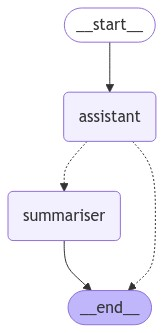

In [8]:
builder = StateGraph(State)
builder.add_node("assistant", call_model)
builder.add_node("summariser", summariser)
builder.add_edge(START, "assistant")
builder.add_conditional_edges("assistant", should_summarise)
builder.add_edge("summariser", END)

graph = builder.compile(checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [21]:
messages = [(HumanMessage("Did Ronaldinho have a relatively short career? He only has one Balon D'or, which is strange?"))]
config = {"configurable": {"thread_id": 13}}


Few ways to stream - sync vs async. 

Values vs Updates

- values: This streams the full state of the graph after each node is called.
- updates: This streams updates to the state of the graph after each node is called.

In [15]:
# Start conversation
for event in graph.stream({"messages": messages}, config, stream_mode="values"):
    for m in event["messages"]:
        m.pretty_print()

================================ Human Message =================================

Can you tell me why Maradona has never won the Ballon D'or? Wasn't he the greatest in the eighties?
================================ Human Message =================================

Can you tell me why Maradona has never won the Ballon D'or? Wasn't he the greatest in the eighties?
================================== Ai Message ==================================

Ah, the legendary Diego Maradona! You're right; he was undoubtedly one of the greatest footballers of the 1980s, and to many, one of the greatest of all time. The reason Maradona never won the Ballon d'Or is because of the award's eligibility criteria during his playing days.

Up until 1995, the Ballon d'Or was restricted to European players only. Since Maradona was from Argentina, he was not eligible to win the award despite his exceptional performances on the field. This is a bit like having a superhero competition but excluding anyone who can fl

### Streaming Tokens

In [22]:
token_buffer = []
async for event in graph.astream_events({"messages": messages}, config, stream_mode="messages", version="v2"):
    if event['event'] == 'on_chat_model_stream' and event['metadata'].get('langgraph_node', '') == 'assistant':
        chunk = event['data']['chunk'].content
        token_buffer.append(chunk)
        if chunk.endswith((" ", ".", ",", "?", "!", ":", ";")): # use as a tuple
            print("".join(token_buffer), end="", flush=True)
            token_buffer = []
        
    # print(f"Node: {event['metadata'].get('langgraph_node', '')}. Type: {event['event']}. Name: {event['name']}.")

Ah, Ronaldinho, the footballer whose smile and skills could light up any stadium! While it might seem like his career at the top was relatively short, it’s important to remember that he was at the elite level for quite some time, especially in the early to mid-2000s.

Ronaldinho’s peak years were primarily during his time at FC Barcelona from 2003 to 2008. During this period, he won a plethora of individual and team honors, including two FIFA World Player of the Year awards (2004 and 2005) and the Ballon d'Or in 2005. His flair, creativity, and joy on the pitch were unmatched, and he played a crucial role in Barcelona's success, including winning the UEFA Champions League in 2006.

While it might appear that his career at the pinnacle was brief, Ronaldinho's style of play relied heavily on flair and physical fitness, which can sometimes lead to a shorter period at the very top compared to other players with different playing styles. Additionally, football is a highly competitive sport,

In [26]:
s = graph.get_state(config=config)
s.values["messages"]

[HumanMessage(content="Can you tell me why Maradona has never won the Ballon D'or? Wasn't he the greatest in the eighties?", additional_kwargs={}, response_metadata={}, id='35016bfb-719a-46ed-b415-1ccdfcf56ce0'),
 AIMessage(content='Ah, Diego Maradona, the maestro of the footballing world! You\'re absolutely right; he was indeed one of the greatest players in the 1980s, if not all time. However, the reason he never won the Ballon d\'Or has more to do with the rules in place during that period than with his performance on the pitch.\n\nUntil 1995, the Ballon d\'Or was only awarded to European players. Since Maradona was from Argentina, he was ineligible to receive the award despite his tremendous talents and achievements. Many people believe that had the rules been different, Maradona would have been a front-runner for the award several times during his illustrious career.\n\nThe Ballon d\'Or rules were changed in 1995 to allow non-European players to be eligible, which is why players l

In [66]:
# using this with local LLM.. still does not provide proper token based streaming
async for msg, metadata in graph.astream({"messages": messages}, config, stream_mode="messages"):
    if msg.content and not isinstance(msg, HumanMessage):
        print(msg.content, end="|", flush=True)

    if isinstance(msg, AIMessageChunk):
        if first:
            gathered = msg
            first = False
        else:
            gathered = gathered + msg

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


A speed demon, eh? I've got just the info you need!

Firstly, let's talk about the fastest SUV on the market today. According to various sources, the title of the fastest SUV is held by the:

1. **Bugatti Chiron Pur Sport**: This hypercar is essentially an SUV, with a staggering 1,600 horsepower (1,180 kW) from its 8.0L W16 engine. It can go from 0-60mph in just 2.4 seconds and has a top speed of 330 km/h (205 mph). However, please note that this is a highly exclusive and extremely expensive vehicle, with a price tag of over $3 million.

However, if you're looking for something more practical and affordable, here are a few other fast SUVs:

2. **Porsche Cayenne Turbo S E-Hybrid**: This luxury SUV boasts 700 horsepower (515 kW) and can accelerate from 0-60mph in just 3.2 seconds.
3. **Lamborghini Urus**: With 641 horsepower (475 kW), this super-SUV can go from 0-60mph in 3.2 seconds.
4. **Audi RS Q7**: This high-performance SUV packs 591 horsepower (440 kW) and can accelerate from 0-60m

NameError: name 'AIMessageChunk' is not defined

## Breakpoints

Use cases for human in the loop:

1. Approval: Interrupt the agent and provide approval for the next action
2. Debugging: Rewind the graph to reproduce or avoid issues
3. Editing: Modify the state manually

Introducing breakpoints as a method to implement human in the loop.

### For Human Approval

Many times it is necessary to interrupt the process and provide approval for tools to be used. Later we will learn how to provide feedback and change the state of the graph. Starting simple first with yes/ no approval to use a tool. Let's import the calculator from the previous section.

In [11]:
# load our stuff
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from langgraph.graph import MessagesState, START, END, StateGraph
from langchain.tools import tool
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from typing_extensions import TypedDict, Literal
from langchain_groq import ChatGroq
from langchain_core.messages import RemoveMessage, trim_messages
from typing import List
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langgraph.prebuilt import ToolNode
from langgraph.prebuilt import tools_condition

import json

# set up the tool

class CalculatorInput(BaseModel):
    a: float = Field(description="first number or operand")
    b: float = Field(description="second number or operand")
    op: Literal["add", "sub", "mult", "div"]


@tool(args_schema=CalculatorInput)
def calculator(a: float, b: float, op: Literal["add", "sub", "mult", "div"]) -> float:
    '''Perform basic arithmetic operations on calculator model. Return a float.'''
    
    if (op == "add"):
        return a + b
    elif (op == "mult"):
        return a * b
    elif (op == 'sub'):
        return a - b
    elif (op == 'div'):
        return a / b
    else:
        return -1.

tools = [calculator]

Setting up the graph, copy paste from previous section. We will use Open AI to ensure proper tool usage first.

In [12]:
class State(MessagesState):
    summary: str;

class MessageUpdate(TypedDict):
    messages: List[str]

# lets create the generic System Message as well:
sys_msg = SystemMessage('You are an everhelpful assistant trying to assist your human friend. You are polite, thoughtful \
and with great sense of nerdy humour.')

def call_model(state: State) -> MessageUpdate:
    summary = state.get('summary', '')
    if summary:
        system_msg = SystemMessage(f'{sys_msg.content}\nSummary of our the conversation thus far:{summary}')
    else:
        system_msg = sys_msg
    result = llm.invoke([system_msg] + state['messages'])
    return {'messages': result}

def summariser(state: State):
    summary = state.get('summary', '')
    if summary:
        summary_message = f'Extend the current summary: {summary} with the conversation thus far.'
    else:
        summary_message = 'Summarise the conversation thus far'
    result = llm.invoke(state['messages'] + [HumanMessage(summary_message)])
    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {'summary': result.content, 'messages': delete_messages}


def should_summarise(state: State) -> Literal['summariser', END]:
    if len(state['messages']) > 6:
        return "summariser"
    else:
        return END

In [4]:
from ollama import Client

cl = Client(host="ollama")
# cl.pull(model="llama3.1")

In [5]:
cl.list()

{'models': [{'name': 'llama3.1:latest',
   'model': 'llama3.1:latest',
   'modified_at': '2024-11-15T23:13:29.426035431Z',
   'size': 4661230766,
   'digest': '42182419e9508c30c4b1fe55015f06b65f4ca4b9e28a744be55008d21998a093',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'llama',
    'families': ['llama'],
    'parameter_size': '8.0B',
    'quantization_level': 'Q4_0'}},
  {'name': 'llama3.2:latest',
   'model': 'llama3.2:latest',
   'modified_at': '2024-11-15T15:18:17.022783503Z',
   'size': 2019393189,
   'digest': 'a80c4f17acd55265feec403c7aef86be0c25983ab279d83f3bcd3abbcb5b8b72',
   'details': {'parent_model': '',
    'format': 'gguf',
    'family': 'llama',
    'families': ['llama'],
    'parameter_size': '3.2B',
    'quantization_level': 'Q4_K_M'}}]}

In [13]:
from langchain_ollama import ChatOllama

memory = MemorySaver()
# openAI_llm = ChatOpenAI(model="gpt-4o", temperature=0.5)
# groq_AI =  ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.5, model_kwargs={"top_p": 0.85})
# llm = openAI_llm.bind_tools(tools=tools)
# llm = groq_AI.bind_tools(tools=tools)



ollama_llm = ChatOllama(
    model="llama3.1",
    temperature=0.1,
    base_url="ollama"
)
llm = ollama_llm.bind_tools(tools)

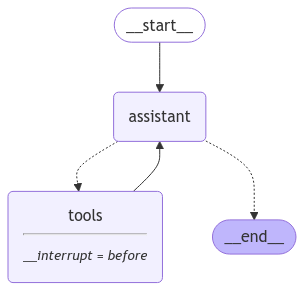

In [14]:
builder = StateGraph(State)
builder.add_node("assistant", call_model)
# builder.add_node("summariser", summariser)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
# builder.add_edge("tools", "assistant")
# builder.add_conditional_edges("assistant", should_summarise)
builder.add_edge("tools", "assistant")

#adding the interruption
graph = builder.compile(interrupt_before=["tools"], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [25]:
config = {"configurable": {"thread_id": 12}}

In [26]:
messages = [(HumanMessage("What is the height of Everest in feet?"))]
# messages = [(HumanMessage("What is the oldest animal on the planet?"))]


In [27]:
approval = False
exit = False
    
for event in graph.stream({"messages": messages}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()
   
    
user_approval = input("Do you want to call the tool? (yes/no): ")

# Check approval
if user_approval.lower() == "yes":
    # If approved, continue the graph execution
    # finally a way to complete the graph with this cycle. We also use a protection of 10 steps
    # making sure it is not broken cycle that loops forever
    counter = 0
    next_step = graph.get_state(config=config).next
    while next_step != () or counter < 10:
        for event in graph.stream(None, config, stream_mode="values"):
            event['messages'][-1].pretty_print()
        next_step = graph.get_state(config=config).next
        counter += 1
        
else:
    print("Operation cancelled by user.")


    
    


================================ Human Message =================================

What is the height of Everest in feet?
================================== Ai Message ==================================
Tool Calls:
  calculator (39b524d4-ddf4-42e6-830b-e1dc92722e7d)
 Call ID: 39b524d4-ddf4-42e6-830b-e1dc92722e7d
  Args:
    a: 8848
    b: 3.28084
    op: mult


Do you want to call the tool? (yes/no):  yes


================================== Ai Message ==================================
Tool Calls:
  calculator (39b524d4-ddf4-42e6-830b-e1dc92722e7d)
 Call ID: 39b524d4-ddf4-42e6-830b-e1dc92722e7d
  Args:
    a: 8848
    b: 3.28084
    op: mult
================================= Tool Message =================================
Name: calculator

29028.87232
================================== Ai Message ==================================

The height of Mount Everest is approximately 29,028.87 feet.


### History and Forking

In [28]:
history_gen = graph.get_state_history(config)
history = list(history_gen)
print(len(history))
history[-3].values["messages"]

5


[HumanMessage(content='What is the height of Everest in feet?', additional_kwargs={}, response_metadata={}, id='849d4e69-4ad4-497a-943c-db98b303bf23'),
 AIMessage(content='', additional_kwargs={}, response_metadata={'model': 'llama3.1', 'created_at': '2024-11-18T17:25:38.552110741Z', 'message': {'role': 'assistant', 'content': '', 'tool_calls': [{'function': {'name': 'calculator', 'arguments': {'a': 8848, 'b': 3.28084, 'op': 'mult'}}}]}, 'done_reason': 'stop', 'done': True, 'total_duration': 331902643, 'load_duration': 13574889, 'prompt_eval_count': 235, 'prompt_eval_duration': 22000000, 'eval_count': 32, 'eval_duration': 294000000}, id='run-0adc4577-579c-45a3-8f6b-9f6b64d3e785-0', tool_calls=[{'name': 'calculator', 'args': {'a': 8848, 'b': 3.28084, 'op': 'mult'}, 'id': '39b524d4-ddf4-42e6-830b-e1dc92722e7d', 'type': 'tool_call'}], usage_metadata={'input_tokens': 235, 'output_tokens': 32, 'total_tokens': 267})]

### Human Feedback from Input

in order for us to supply feedback and change the state we need to add a dummy node that will act as an injector to update the state by collecting the human input.

Graph setup below:

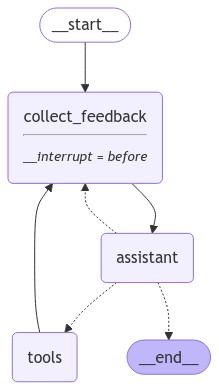

In [35]:
def collect_feedback(state: MessagesState):
    pass # we will use this as a node in the graph, but actually we'll update the state outside.
builder = StateGraph(State)
builder.add_node("assistant", call_model)
builder.add_node("collect_feedback", collect_feedback)
# builder.add_node("summariser", summariser)
builder.add_node("tools", ToolNode(tools))
builder.add_edge(START, "collect_feedback")
builder.add_edge("collect_feedback", "assistant")
builder.add_conditional_edges(
    "assistant",
    # If the latest message (result) from assistant is a tool call -> tools_condition routes to tools
    # If the latest message (result) from assistant is a not a tool call -> tools_condition routes to END
    tools_condition,
)
# builder.add_edge("tools", "assistant")
# builder.add_conditional_edges("assistant", should_summarise)
builder.add_edge("tools", "collect_feedback")

#adding the interruption
graph = builder.compile(interrupt_before=["collect_feedback"], checkpointer=memory)

display(Image(graph.get_graph().draw_mermaid_png()))

In [36]:
config = {"configurable": {"thread_id": 310}}
messages = [(HumanMessage("Help me with a calculation - what is 3 times 7"))]

In [37]:
for event in graph.stream({"messages": messages}, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

q1 = input("Would you like to change the multiplier 7 in '3 times 7'? y/n")

if q1 == 'y':
    q2 = input("what should we multiply by? (enter a number): ")
    if isinstance(int(q2), (float, int)):
        current_state = graph.get_state(config)
        state_config = current_state.config
        # instead of adding to the conversation, overwrite by supplying current ID
        updated_state = graph.update_state(
            state_config,
            {
                "messages": [HumanMessage(
                        content=f"Multiply 3 times {q2}",
                        id=current_state.values["messages"][0].id # get the current ID
                    )]
            },
            as_node="collect_feedback"
        )
        

        for event in graph.stream(None, updated_state, stream_mode="values"):
            event['messages'][-1].pretty_print()
    else:
        print("Invalid numeric input")
        for event in graph.stream(None, config, stream_mode="values"):
            event['messages'][-1].pretty_print()
else:
    print("Continuing with '3 times 7'")
    for event in graph.stream(None, config, stream_mode="values"):
        event['messages'][-1].pretty_print()

================================ Human Message =================================

Help me with a calculation - what is 3 times 7


Would you like to change the multiplier 7 in '3 times 7'? y/n n


Continuing with '3 times 6'
================================ Human Message =================================

Help me with a calculation - what is 3 times 7
================================== Ai Message ==================================
Tool Calls:
  calculator (call_LNwW5tfZxeKxcP3fJI6WYqyK)
 Call ID: call_LNwW5tfZxeKxcP3fJI6WYqyK
  Args:
    operands: {'a': 3, 'b': 7}
    op: mult
================================= Tool Message =================================
Name: calculator

21.0


In [38]:
for event in graph.stream(None, config, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================= Tool Message =================================
Name: calculator

21.0
================================== Ai Message ==================================

Multiplying 3 by 7 gives you 21. It's a lucky number, like the number of sides on a standard die plus one!


## Parallelisation

Fanning out and Fanning in nodes in a graph. We must use a reducer that manages how they are added to the state. If not, there will be an error that two nodes are updating the state at the same time.

### Working with Searches in Parallel

Lets try to get results from Tavily and Wikipedia at the same time and combine them to produce a summarised result on a query via an LLM

In [21]:
!pip install wikipedia
!pip install -U google-api-python-client
!pip install langchain_google_community

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=b87dca8a7c0bf347d4242ebb75dd80eb2805163eb0e1227225054831323fb62d
  Stored in directory: /home/jovyan/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 69.7 MB/s eta 0:00:00


In [3]:
# load our stuff
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from langgraph.graph import MessagesState, START, END, StateGraph
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from typing_extensions import TypedDict, Literal, Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import RemoveMessage, trim_messages
import json, operator

from langchain_core.documents import Document
from langchain_community.document_loaders import WikipediaLoader
from langchain_community.tools.tavily_search import TavilySearchResults


/opt/conda/lib/python3.11/site-packages/langgraph/graph/graph.py:30: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langgraph.pregel import Channel, Pregel
/opt/conda/lib/python3.11/site-packages/pydantic/_internal/_config.py:341: UserWarning: Valid config keys have changed in V2:
* 'allow_population_by_field_name' has been renamed to 'populate_by_name'
  warnings.warn(message, UserWarning)


PydanticUserError: The `__modify_schema__` method is not supported in Pydantic v2. Use `__get_pydantic_json_schema__` instead in class `SecretStr`.

For further information visit https://errors.pydantic.dev/2.8/u/custom-json-schema

In [6]:
class State(TypedDict):
    question: str
    answer: str
    context: Annotated[list, operator.add]

In [7]:
def search_web(state):
    
    """ Retrieves docs from a web search """
    
    # Search
    tavily_search = TavilySearchResults(max_results=3)
    searches = tavily_search.invoke(state['question'])

    #format them
    docs = "\n\n----------\n\n".join([f'<Document href="{doc["url"]}">\n{doc["content"]}\n</Document>' for doc in searches])
    return {"context": [docs]}

def search_wiki(state):
    
    """ Retrieves docs from wikipedia """
    
    # Search
    searches = WikipediaLoader(query=state['question'], load_max_docs=2).load()

    # Format
    docs = "\n\n----------\n\n".join([
        f'<Document source"={doc.metadata["source"]}" page="{doc.metadata.get("page", "")}">\n{doc.page_content}\n</Document>' 
        for doc in searches
    ])
    return {"context": [docs]}

def generate_answer(state):

    """ Node to answer a question with LLM  based on a context from the searches """

    context = state["context"]
    question = state["question"]
    system = [SystemMessage('You are a talented researches that answers questions based on supplied context')]
    human = [HumanMessage(f'Please answer the question based on the context\n\nContext: {context}\n\nQuestion: {question}')]

    answer = llm.invoke(system + human)

    return {"answer": answer}

    

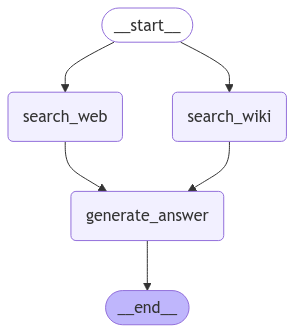

In [8]:
# Building the Graph

builder = StateGraph(State)

builder.add_node("search_web", search_web)
builder.add_node("search_wiki", search_wiki)
builder.add_node("generate_answer", generate_answer)

builder.add_edge(START, "search_web")
builder.add_edge(START, "search_wiki")
builder.add_edge("search_web", "generate_answer")
builder.add_edge("search_wiki", "generate_answer")
builder.add_edge("generate_answer", END)

graph = builder.compile()

display(Image(graph.get_graph().draw_mermaid_png()))


In [2]:
# Initialise the LLM (try Open AI, then Groq)

# llm = ChatOpenAI(model="gpt-4o", temperature=0.1)
llm = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.5, model_kwargs={"top_p": 0.85})
# llm_factory = OpenLLMWithHF(model="../ext_models/Meta-Llama-3.1-8B-Instruct", max_tokens=1024, temperature=0.3, chat=False)

NameError: name 'ChatGroq' is not defined

In [4]:
# llm = llm_factory.get_model()

Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [13]:
result = graph.invoke({"question": "How high can party helium filled balloons fly before bursting?"})

In [14]:
print(result['answer'].content)

The height to which a party helium-filled balloon can fly before bursting depends on various factors such as the temperature and pressure of the atmosphere, the size of the balloon, and the amount of helium it contains. Generally, a party helium-filled balloon can reach heights of up to 20 miles (32 kilometers) or more before it bursts due to the pressure difference between the inside and outside of the balloon.


In [12]:
print(result['context'])

['<Document href="https://mistydaydream.com/blog/how-high-can-a-helium-balloon-go/">\nWell, most balloons filled with helium are able to rise anywhere from 10,000 to 20,000 feet into the atmosphere before they burst—that\'s more than 3 miles up! However, some particularly hardy balloons have been known to rise as high as 100,000 feet or more! That puts them above some commercial aircraft flying at cruising altitudes!\n</Document>\n\n----------\n\n<Document href="https://www.physicsforums.com/threads/how-far-would-a-helium-balloon-rise-if-it-never-burst.491816/">\nApr 19, 2011. Balloon Helium Rise. In summary, the maximum height a helium balloon can reach without bursting would depend on the material used to construct the balloon and the elasticity of the balloon. However, with the use of a solenoid valve and an unpressurized bag to release excess gas, the balloon could potentially reach extremely high\n</Document>\n\n----------\n\n<Document href="https://www.sciencefocus.com/science/ho

## Map Reduce Pattern

The map reduce pattern is used to spawn nodes in parallel that can produce output on a task and collate the results in a list through a state reducer. Then another node would analyse the data and make decisions.

Let's do a test. We will ask an LLM to provide n-number of famous people in certain century. For each of these people, we will ask the LLM to provide 3 significant deeds that made them famous. We will gather all deeds in a list and then ask an LLM judge to rate and choose what is the most significat deed and explain why it has chosen that.

In [37]:
# Includes
from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file
from langgraph.graph import MessagesState, START, END, StateGraph
from langgraph.constants import Send
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from langchain_openai import ChatOpenAI
from IPython.display import Image, display
from typing_extensions import TypedDict, Literal, Annotated
from langchain_groq import ChatGroq
from langchain_core.messages import RemoveMessage, trim_messages
from pydantic import BaseModel, Field
import json, operator

from langchain.output_parsers import ListOutputParser

# Schemas

class MostSignificant(BaseModel): # e.g. {"deed": "some deed", "person": "Thomas Jefferson"}
    deed: str
    person: str
    why_is_most_significant: str = Field(description="Explain why is this event the most significant in this time period")


class ImportantEvents(BaseModel):
    important_events: str # e.g. Thomas Jefferson's achievements: 1. ..., 2. ... 
    
class People(BaseModel):
    people: list[str]

class Person(TypedDict):
    person: str

class InputState(TypedDict):
    period: str

class State(TypedDict):
    people: list[str]
    period: str
    important_events: Annotated[list, operator.add]
    most_significant: MostSignificant
    

In [38]:
from modules import OpenLLMCreatorHF
from langchain_ollama import ChatOllama
from ollama import Client

# must make sure we are running in docker-compose so that we can address local ollama service
# if the model is not pulled yet, we must use Client to pull the chosen model

# cl = Client(host="ollama")
# cl.pull(model="llama3.2")

llm = ChatOllama(
    model="llama3.1",
    temperature=0.12,
    base_url="ollama"
)

# llm = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.33, model_kwargs={"top_p": 0.9})
# llm_factory = OpenLLMCreatorHF(model="../ext_models/Ministral-8B-Instruct-2410", temperature=0.2, top_p=0.85)
# llm = llm_factory.get_model()

We use the `Send` to create events for each `Person`.

This is very useful! It can automatically parallelize generation for any number of subjects.

generate_events: the name of the node in the graph
{"person": person}: the state to send
Send allow you to pass any state that you want to a node! It does not have to align with overall State.

In this case, generate_events is using its own internal state, and we can popular this via Send.

In [39]:

def generate_people(state: InputState):
    prompt = f"""
    You are a famous, knowledgeable historian. You task is to generate a list of 5 significant,
    famous people who lived in particular time period. Provide just the list of strings, nothing else.
    The time period is: {state['period']}"""
    result = llm.invoke(prompt)
    print(result.content)
    return {"people": result.content.split('\n')}

def continue_to_events(state: People):
    print("here", state)
    return [Send("generate_events", {"person": person}) for person in state["people"]]

def generate_events(state: Person):
    prompt = f"""
    You are a famous, knowedgeable historian. Your task is to generate a list of 3 significant achievements
    of a famous person. Here is the person {state["person"]}. Return the result like this:
    Person's name: 1. achievement 1, 2. achievement, 3. achievement 3
    """
    result = llm.invoke(prompt)
    return {"important_events": [result.content]}

def generate_most_significant(state: State):
    list = "\n\n".join(state["important_events"])
    prompt = f"""
    You are a famous, knowedgeable historian. Your task is to decide which of the listed significant events
    by different candidates has had the most impact on humanity. You need to write a 100 words 'why' you have deduced so. Below is the
    list of people with their accomplishments. Choose only one person and one most significant accomplishement.
    
    {list}
    """.strip()
    result = llm.with_structured_output(MostSignificant).invoke(prompt)
    return {"most_significant": result}
    

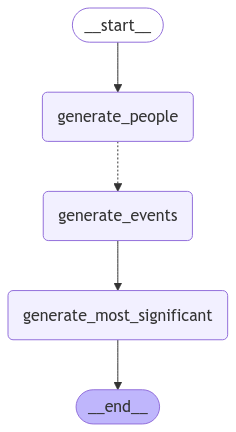

In [40]:
builder = StateGraph(State)
builder.add_node("generate_people", generate_people)
builder.add_node("generate_events", generate_events)
builder.add_node("generate_most_significant", generate_most_significant)
builder.add_edge(START, "generate_people")
builder.add_conditional_edges("generate_people", continue_to_events, ["generate_events"])
builder.add_edge("generate_events", "generate_most_significant")
builder.add_edge("generate_most_significant", END)

graph = builder.compile()
Image(graph.get_graph().draw_mermaid_png())

In [43]:
messages = []
for s in graph.stream({"period": "the first half of twentieth century"}):
    messages.append(s)
    print(s)


1. Albert Einstein
2. Mahatma Gandhi
3. Frida Kahlo
4. Martin Luther King Jr.
5. Joseph Stalin
here {'people': ['1. Albert Einstein', '2. Mahatma Gandhi', '3. Frida Kahlo', '4. Martin Luther King Jr.', '5. Joseph Stalin'], 'period': 'the first half of twentieth century'}
{'generate_people': {'people': ['1. Albert Einstein', '2. Mahatma Gandhi', '3. Frida Kahlo', '4. Martin Luther King Jr.', '5. Joseph Stalin']}}
{'generate_events': {'important_events': ['Mahatma Gandhi:\n\n1. Led India to independence from British rule through non-violent resistance and civil disobedience movements.\n2. Developed and popularized the concept of "Satyagraha" (Truth Force), a philosophy that emphasizes the power of truth and non-violence in achieving social change.\n3. Inspired leaders such as Martin Luther King Jr., Nelson Mandela, and Aung San Suu Kyi with his methods of peaceful protest and civil rights activism.']}}
{'generate_events': {'important_events': ['Frida Kahlo:\n\n1. Overcame physical disabi

In [44]:


pprint(messages[-1]['generate_most_significant']['most_significant'])

MostSignificant(deed="Delivered his iconic 'I Have a Dream' speech during the March on Washington for Jobs and Freedom in 1963", person='Martin Luther King Jr.', why_is_most_significant="This event had the most significant impact on humanity because it galvanized support for the passage of the Civil Rights Act of 1964, marking a pivotal moment in the struggle for racial equality and social justice. The speech's powerful message and call to action continue to inspire movements for human rights and freedom around the world.")


In [ ]:
# using the Groq. Still local LLMs suck in these scenarios.

In [70]:
from modules import OpenLLMCreatorHF

llm_factory = OpenLLMCreatorHF(model="../ext_models/Ministral-8B-Instruct-2410", temperature=0.2, top_p=0.85)

In [71]:
llm = llm_factory.get_model()

You are using the default legacy behaviour of the <class 'transformers.models.llama.tokenization_llama_fast.LlamaTokenizerFast'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565 - if you loaded a llama tokenizer from a GGUF file you can ignore this message.


Loading checkpoint shards:   0%|          | 0/4 [00:00<?, ?it/s]

In [89]:
ai_msg = llm.invoke([SystemMessage("You are a helpful asisstant and a professor of history that answers questions from your human friend."), 
                     HumanMessage("Can you write a 300 word essay about Ragnar Lothbrok in the context of Viking mythology and lore.")])

Setting `pad_token_id` to `eos_token_id`:None for open-end generation.


In [90]:
print(ai_msg.content)

Ragnar Lothbrok, a legendary Viking chieftain, is a prominent figure in Norse mythology and lore, often depicted as a fearless warrior and a cunning strategist. His name, Ragnar Lothbrok, translates to "Ragnar the Hairy-Breeches," a moniker that reflects his distinctive appearance and perhaps his reputation for being a wild and untamed figure.

Ragnar Lothbrok is best known for his role in the sagas, particularly the "Saga of Ragnar Lothbrok" and the "Saga of the Jomsvikings." In these tales, he is portrayed as a formidable leader who led numerous raids and conquests, including the sacking of Paris and the invasion of England. His most famous exploit is the raid on the monastery of Lindisfarne in 793, which marked the beginning of the Viking Age in England.

In Viking mythology, Ragnar Lothbrok is often associated with the god Odin, the All-Father. Like Odin, Ragnar is known for his wisdom, cunning, and his ability to inspire loyalty among his followers. He is also depicted as a skille

## Research Assistant

### Goal

1. Source Selection
   - Users can use the input sources for research
2. Planning
   - Users would provide a topic and the system would spawn a team of AI analysts that would focus on sub-topics.
   - Human in the loop with refine these sup-topics before research begins
3. LLMs
   - Each analyst will conduct interviews with an expert AI using selected sources
   - It will be a multiturn conversation until certain criteria is met (we will set max number of questions)
   - The interviews will be captured in a sub-graph with internal state
4. Research
   - Experts will gather information by using sources to answer the questions in parallel
   - All interviews will be conducted in paraller as well through map-reduce
5. Output a report
   - The gathered insights from each interview will be syntehsized into a final report.
   - We'll use custom prompts across the whole solution to produce flexible output.


### Generating the Analysts

In [45]:
!pip install wikipedia
!pip install -U google-api-python-client
!pip install langchain_google_community
!pip install langchain_groq

  Preparing metadata (setup.py) ... done
  Created wheel for wikipedia: filename=wikipedia-1.4.0-py3-none-any.whl size=11678 sha256=2a00e67ca853d8e69c3a464316419b072513a098245f633b68816d46c5375e12
  Stored in directory: /home/jovyan/.cache/pip/wheels/63/47/7c/a9688349aa74d228ce0a9023229c6c0ac52ca2a40fe87679b8
Successfully built wikipedia
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.6/12.6 MB 68.4 MB/s eta 0:00:00


In [6]:
from typing import List
from pydantic import BaseModel, Field
from typing_extensions import TypedDict, Literal, Annotated
from langchain_openai import ChatOpenAI
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama
from IPython.display import Image, display
import sqlite3

import operator

from langchain_core.messages import get_buffer_string
from langchain_community.tools.tavily_search import TavilySearchResults

from dotenv import load_dotenv, find_dotenv
_ = load_dotenv(find_dotenv()) # read local .env file

USE_LOCAL = False # set a flag wheather to use a local model provided by Ollama
MODEL = "llama3.1:8b-instruct-fp16"
CONF_ID = 144 # set a unified memory thread ID accross the execution. change for new executions

class Analyst(BaseModel):
    affiliation: str = Field(
        description="Primary affiliation of the analyst.",
    )
    name: str = Field(
        description="Name of the analyst."
    )
    role: str = Field(
        description="Role of the analyst in the context of the topic.",
    )
    description: str = Field(
        description="Description of the analyst focus, concerns, and motives.",
    )
    @property
    def persona(self) -> str:
        return f"Name: {self.name}\nRole: {self.role}\nAffiliation: {self.affiliation}\nDescription: {self.description}\n"

class Perspectives(BaseModel):
    analysts: List[Analyst] = Field(
        description="Comprehensive list of analysts with their roles and affiliations.",
    )

class GenerateAnalystsState(TypedDict):
    topic: str # Research topic
    max_analysts: int # Number of analysts
    human_analyst_feedback: str # Human feedback
    analysts: List[Analyst] # Analyst asking questions

# llm = ChatGroq(model="llama3-groq-70b-8192-tool-use-preview", temperature=0.33, model_kwargs={"top_p": 0.9})
# llm = ChatOpenAI(model="gpt-4o", temperature=0.33)
if USE_LOCAL:
    
    llm = ChatOllama(
        model=MODEL,
        temperature=0.12,
        base_url="ollama"
        
    )
else:
    llm = ChatGroq(model="llama-3.3-70b-versatile", temperature=0.33, model_kwargs={"top_p": 0.9})

In [7]:
# Using the instructor to structure output of Ollama local models

llm

ChatGroq(client=<groq.resources.chat.completions.Completions object at 0x7d6c3950ffb0>, async_client=<groq.resources.chat.completions.AsyncCompletions object at 0x7d6c38b3d400>, model_name='llama-3.3-70b-versatile', temperature=0.33, model_kwargs={'top_p': 0.9}, groq_api_key=SecretStr('**********'))

In [8]:
from langgraph.graph import MessagesState, START, END, StateGraph
from pprint import pprint
from langchain_core.messages import HumanMessage, SystemMessage, AIMessage
from langgraph.checkpoint.memory import MemorySaver
from openai import OpenAI

import instructor

analyst_instructions="""You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
{topic}
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
Feedback: {human_analyst_feedback}
    
3. Determine the most interesting themes based upon documents and / or any feedback above.
                    
4. Pick the top {max_analysts} themes.

5. Assign one analyst to each theme."""

def instructed():
    instructed_llm = instructor.from_openai(OpenAI(
            base_url="http://ollama:11434/v1",
            api_key="ollama",  # required, but unused
        ),
        mode=instructor.Mode.JSON
    )
    return instructed_llm

def create_analysts(state: GenerateAnalystsState):

    """ Create the analysts """

    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    # condition = get_max_analysts(max_analysts, human_analyst_feedback)
            
    # Enforce structured output
    structured_llm = llm.with_structured_output(Perspectives)

    # System message
    system_message = analyst_instructions.format(topic=topic,
                                                            human_analyst_feedback=human_analyst_feedback, 
                                                            max_analysts=max_analysts)
    print("SM: ", system_message)
    # Generate question 
    result = structured_llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content="Generate the set of analysts.")])
    
    # Write the list of analysis to state
    return {"analysts": result.analysts}

def create_analysts_ollama(state: GenerateAnalystsState):

    """ Create the analysts with Ollama """
    
    topic = state["topic"]
    max_analysts = state["max_analysts"]
    human_analyst_feedback=state.get('human_analyst_feedback', '')

    instructed_llm = instructed()

     # System message
    system_message = analyst_instructions.format(topic=topic,
                                                human_analyst_feedback=human_analyst_feedback, 
                                                max_analysts=max_analysts)
    messages = [
                {"role": "system", "content": system_message},
                {"role": "user", "content": "Generate the set of analysts."}
               ]
    result = instructed_llm.chat.completions.create(
                model=MODEL,
                messages=messages,
                response_model=Perspectives)
    
    return {"analysts": result.analysts}

def get_max_analysts(max_analysts, human_analyst_feedback) -> str: # not used at the moment

    """ Conditionally alter the prompt based on the human feedback and the maximum allowed analysts """

    if human_analyst_feedback != '':
        return "Provide one theme based on the feedback above"
    else:
        return f"Pick the top {max_analysts} themes."

def human_feedback(state: GenerateAnalystsState):

    """ No-op node to provide interruption and supply human feedback """
    
    pass

def should_continue(state:GenerateAnalystsState):

    """ Conditional edge to loop back to create analysts if human feedback """

     # Check if human feedback
    human_analyst_feedback=state.get('human_analyst_feedback', None)
    if human_analyst_feedback:
        return "create_analysts"
    
    # Otherwise end
    return END



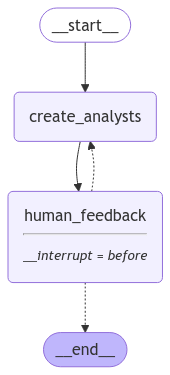

In [9]:
# Add nodes and edges 
builder = StateGraph(GenerateAnalystsState)
builder.add_node("create_analysts", create_analysts if not USE_LOCAL else create_analysts_ollama)
builder.add_node("human_feedback", human_feedback)
builder.add_edge(START, "create_analysts")
builder.add_edge("create_analysts", "human_feedback")
builder.add_conditional_edges("human_feedback", should_continue, ["create_analysts", END])

# Compile
memory = MemorySaver()
graph = builder.compile(interrupt_before=['human_feedback'], checkpointer=memory)

# View
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))

In [10]:
# Input
max_analysts = 3 
topic = "The benefits of adopting LangGraph as an agent framework"
config = {"configurable": {"thread_id": CONF_ID}}

In [11]:
# Run the graph until the first interruption
for event in graph.stream({"topic":topic,"max_analysts":max_analysts}, config, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50)  

SM:  You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
The benefits of adopting LangGraph as an agent framework
        
2. Examine any editorial feedback that has been optionally provided to guide creation of the analysts: 
        
Feedback: 
    
3. Determine the most interesting themes based upon documents and / or any feedback above.
                    
4. Pick the top 3 themes.

5. Assign one analyst to each theme.
Name: Dr. Rachel Kim
Affiliation: Stanford University
Role: AI Researcher
Description: Focuses on the benefits of LangGraph in natural language processing and its potential to improve human-computer interaction
--------------------------------------------------
Name: Dr. Liam Chen
Affiliation: Google
Role: Software Engineer
Description: Examines the advantages of adopting LangGraph as an agent framework for building scalable and efficient AI systems
------------------------------------

In [12]:
# Get state and look at next node
state = graph.get_state(config)
state.next

('human_feedback',)

In [13]:
# We now update the state as if we are the human_feedback node
graph.update_state(config, {"human_analyst_feedback": 
                            "Add in someone from an AI startup to add an entrepreneur perspective"}, as_node="human_feedback")

{'configurable': {'thread_id': 144,
  'checkpoint_ns': '',
  'checkpoint_id': '1efe9263-1956-661d-8002-d54a959a22ce'}}

In [14]:
# Continue the graph execution
for event in graph.stream(None, config, stream_mode="values"):
    # Review
    analysts = event.get('analysts', '')
    if analysts:
        for analyst in analysts:
            print(f"Name: {analyst.name}")
            print(f"Affiliation: {analyst.affiliation}")
            print(f"Role: {analyst.role}")
            print(f"Description: {analyst.description}")
            print("-" * 50) 

Name: Dr. Rachel Kim
Affiliation: Stanford University
Role: AI Researcher
Description: Focuses on the benefits of LangGraph in natural language processing and its potential to improve human-computer interaction
--------------------------------------------------
Name: Dr. Liam Chen
Affiliation: Google
Role: Software Engineer
Description: Examines the advantages of adopting LangGraph as an agent framework for building scalable and efficient AI systems
--------------------------------------------------
Name: Dr. Ava Moreno
Affiliation: MIT
Role: Cognitive Scientist
Description: Investigates the cognitive benefits of using LangGraph in AI development, including enhanced decision-making and problem-solving capabilities
--------------------------------------------------
SM:  You are tasked with creating a set of AI analyst personas. Follow these instructions carefully:

1. First, review the research topic:
The benefits of adopting LangGraph as an agent framework
        
2. Examine any edito

In [15]:
# If we are satisfied, then we simply supply no feedback
further_feedack = None
graph.update_state(config, {"human_analyst_feedback": 
                            further_feedack}, as_node="human_feedback")


{'configurable': {'thread_id': 144,
  'checkpoint_ns': '',
  'checkpoint_id': '1efe9263-a685-677d-8004-c149ba5127b7'}}

In [16]:
for event in graph.stream(None, config, stream_mode="updates"):
    print("--Node--")
    node_name = next(iter(event.keys()))
    print(node_name)

In [17]:

final_state = graph.get_state(config)
analysts = final_state.values.get('analysts')
for analyst in analysts:
    print(f"Name: {analyst.name}")
    print(f"Affiliation: {analyst.affiliation}")
    print(f"Role: {analyst.role}")
    print(f"Description: {analyst.description}")
    print("-" * 50) 

Name: Dr. Rachel Kim
Affiliation: Stanford University
Role: Researcher
Description: Expert in AI frameworks, focusing on the benefits of adopting LangGraph for research purposes
--------------------------------------------------
Name: Alex Chen
Affiliation: AI Startup Founder
Role: Entrepreneur
Description: Interested in the potential of LangGraph to drive innovation and growth in the AI industry
--------------------------------------------------
Name: Dr. Liam Patel
Affiliation: McKinsey & Company
Role: Industry Consultant
Description: Specializing in the practical applications of LangGraph in various industries, including its potential for cost savings and efficiency gains
--------------------------------------------------


### Conduct the Interview

Now that we have generated a list of analysts, it is type to generate questions and make the LLM answer them.

Defining the InterviewState below. This will eventually be part of a sub-graph that will use its own state and run in parallel for each analyst.

#### Generate Question

In [22]:

class InterviewState(MessagesState):
    max_num_turns: int # Number turns of conversation
    context: Annotated[list, operator.add] # Source docs
    analyst: Analyst # Analyst asking questions
    search_query: str # the search engine optimised query based on the question
    interview: str # Interview transcript
    sections: list # Final key we duplicate in outer state for Send() API

class SearchQuery(BaseModel):
    search_query: str = Field(description="Generated search query for the expert")

In [24]:
question_instructions = """You are an analyst tasked with interviewing an expert to learn about a specific topic. 

Your goal is boil down to interesting and specific insights related to your topic.

1. Interesting: Insights that people will find surprising or non-obvious.
        
2. Specific: Insights that avoid generalities and include specific examples from the expert.

Here is your topic of focus and set of goals: {goals}
        
Begin by introducing yourself using a name that fits your persona, and then ask your question.

Continue to ask questions to drill down and refine your understanding of the topic.
        
When you are satisfied with your understanding, complete the interview with: "Thank you so much for your help!"

Remember to stay in character throughout your response, reflecting the persona and goals provided to you."""
def convert_messages(messages) -> List:
    converted = []
    for msg in messages:
        if isinstance(msg, SystemMessage):
            converted.append({"role": "system", "content": msg.content})
        elif isinstance(msg, HumanMessage):
            converted.append({"role": "user", "content": msg.content})
        elif isinstance(msg, AIMessage):
            converted.append({"role": "ai", "content": msg.content})
    return converted

def generate_question(state: InterviewState):
    
    """ Node to generate a question """

    # Get state
    analyst = state["analyst"]
    messages = state["messages"]

    # Generate question 
    system_message = question_instructions.format(goals=analyst.persona)
    question = llm.invoke([SystemMessage(content=system_message)]+messages)
        
    # Write messages to state
    return {"messages": [question]}

#### Generate Answer

The expert will gather information from multiple sources in parallel to answer questions.

For example, we can use:

- Specific web sites e.g., via WebBaseLoader
- Indexed documents e.g., via RAG
- Web search
- Wikipedia search

In [25]:

# Web search tool
from langchain_community.tools.tavily_search import TavilySearchResults
from langchain_google_community import GoogleSearchAPIWrapper

# Search the web
google_search = GoogleSearchAPIWrapper()
tavily_search = TavilySearchResults(max_results=3)

# Wikipedia search tool
from langchain_community.document_loaders import WikipediaLoader

In [42]:
search_docs = google_search.run("When was the last El Classico played?")
#search_docs = google_search.
tavily_docs = tavily_search.invoke("When was the last El Classico played")

In [43]:
# tryme = google_api.results("Obama's first name is?", 3)
tavily_docs

[{'url': 'https://en.wikipedia.org/wiki/El_Clásico',
  'content': 'First, during El Clásico that took place on 30 April 1988, where Real Madrid won the championship on the previous round. Then, three years later, when Barcelona won the championship two rounds before El Clásico on 8 June 1991. [57] The last pasillo, and most recent, took place on 7 May 2008, and this time Real Madrid had won the championship'},
 {'url': 'https://worldsoccertalk.com/history-of-el-clasico-real-madrid-vs-barcelona/',
  'content': 'History of El Clásico - Real Madrid vs Barcelona - World Soccer Talk History of El Clásico – Real Madrid vs Barcelona However, Real Madrid maintains a significant lead in La Liga, having won 35 league championships, which is a Spanish record and is eight ahead of Barcelona. Here are all of the details of where you can watch Guatemala vs Martinique on US television and via legal streaming: WHO Guatemala vs Martinique WHAT Concacaf Nations League WHEN 10pm ET / 7pm PT • Thursday, S

In [26]:
print("\n\n---\n\n".join(
        [
            f'<Document href="{doc["link"]}"/>\n{doc["title"]}\n{doc["snippet"]}\n</Document>'
            for doc in tryme
        ]))

<Document href="https://obamawhitehouse.archives.gov/sites/default/files/rss_viewer/birth-certificate-long-form.pdf"/>
Birth Certificate - Obama White House Archives
Full Name of Father. BARACK. 9. HUSSEIN. OBAMA. 10. Age of Father. 11. Birthplace (Island, State ...
</Document>

---

<Document href="https://en.wikipedia.org/wiki/Barack_Obama"/>
Barack Obama - Wikipedia
Barack Hussein Obama II (born August 4, 1961) is an American politician who served as the 44th president of the United States from 2009 to 2017.
</Document>

---

<Document href="https://www.reddit.com/r/PrequelMemes/comments/mm08dk/we_did_it_boys_we_found_obamas_last_name/"/>
we did it boys, we found Obama's last name : r/PrequelMemes
Apr 7, 2021 ... Technically, that's a trick question. Obama IS his last name. His first name is Barack.
</Document>


In [110]:
# import json, ast
# # deserialisable = search_docs.replace("'", '"').replace('\\xa0', ' ')
# l = ast.literal_eval(search_docs)

In [26]:

# Search query writing
search_instructions = """You will be given a conversation between an analyst and an expert. 
Your goal is to generate a well-structured query for use in retrieval and / or web-search related to the conversation.    
First, analyze the full conversation.
Pay particular attention to the final question posed by the analyst.
Convert this final question into a well-structured web search query"""

def generate_search_query(state: InterviewState):

    """ Generate the search engine query based on USE_LOCAL """

    messages = state["messages"]
    if USE_LOCAL:
        instruct_llm = instructed()
         
        converted = [{"role": "system", "content": search_instructions}] + convert_messages(messages)
        print("converted", converted)
        result = instruct_llm.chat.completions.create(
                    model=MODEL,
                    messages=converted,
                    response_model=SearchQuery)
        print("result", result)
    else:
        structured_llm = llm.with_structured_output(SearchQuery)
        result = structured_llm.invoke([SystemMessage(search_instructions)]+state['messages'])
    print("THE SEARCH QUERY IS:", result.search_query)
    return {"search_query": result.search_query}

def search_with_tavily(state: InterviewState):
    
    """ Retrieve docs from Tavily """

    # Search
    search_docs = tavily_search.invoke(state["search_query"])

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["url"]}"/>\n{doc["content"]}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 

def search_with_google(state: InterviewState):

    """ Retreive docs from google """

    
    # Search
    search_docs = google_search.results(state["search_query"], 4)

    # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document href="{doc["link"]}"/>\n{doc["title"]}\n{doc["snippet"]}\n</Document>'
            for doc in search_docs
        ]
    )
    return {"context": [formatted_search_docs]}

def search_wikipedia(state: InterviewState):
    
    """ Retrieve docs from wikipedia """
    
    # Search
    search_docs = WikipediaLoader(query=state["search_query"], 
                                  load_max_docs=2).load()

     # Format
    formatted_search_docs = "\n\n---\n\n".join(
        [
            f'<Document source="{doc.metadata["source"]}" page="{doc.metadata.get("page", "")}"/>\n{doc.page_content}\n</Document>'
            for doc in search_docs
        ]
    )

    return {"context": [formatted_search_docs]} 



In [39]:
type(tavily_search)

langchain_community.tools.tavily_search.tool.TavilySearchResults

In [27]:
answer_instructions = """You are an expert being interviewed by an analyst.

Here is analyst area of focus: {goals}. 
        
You goal is to answer a question posed by the interviewer.

To answer question, use this context:
        
{context}

When answering questions, follow these guidelines:
        
1. Use only the information provided in the context. 
        
2. Do not introduce external information or make assumptions beyond what is explicitly stated in the context.

3. The context contain sources at the topic of each individual document.

4. Include these sources your answer next to any relevant statements. For example, for source # 1 use [1]. 

5. List your sources in order at the bottom of your answer. [1] Source 1, [2] Source 2, etc
        
6. If the source is: <Document source="assistant/docs/llama3_1.pdf" page="7"/>' then just list: 
        
[1] assistant/docs/llama3_1.pdf, page 7 
        
And skip the addition of the brackets as well as the Document source preamble in your citation."""
def generate_answer(state: InterviewState):

    """ The expert answer based on context and last question """
    
    analyst = state["analyst"]
    goals = analyst.persona
    messages = state["messages"]
    context = state["context"]

    system_message = answer_instructions.format(goals=goals, context=context)

    answer = llm.invoke([SystemMessage(system_message)] + messages)
    # Name the message as coming from the expert
    answer.name = "expert"
    
    return {"messages": [answer]}

def save_interview(state: InterviewState):
    
    """ Save interviews """

    # Get messages
    messages = state["messages"]
    
    # Convert interview to a string
    interview = get_buffer_string(messages)
    
    # Save to interviews key
    return {"interview": interview}

def route_messages(state: InterviewState, 
                   name: str = "expert"):

    """ Route between question and answer """
    
    # Get messages
    messages = state["messages"]
    max_num_turns = state.get('max_num_turns',2)

    # Check the number of expert answers 
    num_responses = len(
        [m for m in messages if isinstance(m, AIMessage) and m.name == name]
    )

    # End if expert has answered more than the max turns
    if num_responses >= max_num_turns:
        return 'save_interview'

    # This router is run after each question - answer pair 
    # Get the last question asked to check if it signals the end of discussion
    last_question = messages[-2]
    
    if "Thank you so much for your help" in last_question.content:
        return 'save_interview'
    return "ask_question"


In [28]:
section_writer_instructions = """You are an expert technical writer. 
            
Your task is to create a short, easily digestible section of a report based on a set of source documents.

1. Analyze the content of the source documents: 
- The name of each source document is at the start of the document, with the <Document tag.
        
2. Create a report structure using markdown formatting:
- Use ## for the section title
- Use ### for sub-section headers
        
3. Write the report following this structure:
a. Title (## header)
b. Summary (### header)
c. Sources (### header)

4. Make your title engaging based upon the focus area of the analyst: 
{focus}

5. For the summary section:
- Set up summary with general background / context related to the focus area of the analyst
- Emphasize what is novel, interesting, or surprising about insights gathered from the interview
- Create a numbered list of source documents, as you use them
- Do not mention the names of interviewers or experts
- Aim for approximately 300 words maximum
- Use numbered sources in your report (e.g., [1], [2]) based on information from source documents
        
6. In the Sources section:
- Include all sources used in your report
- Provide full links to relevant websites or specific document paths
- Separate each source by a newline. Use two spaces at the end of each line to create a newline in Markdown.
- It will look like:

### Sources
[1] Link or Document name
[2] Link or Document name

7. Be sure to combine sources. For example this is not correct:

[3] https://ai.meta.com/blog/meta-llama-3-1/
[4] https://ai.meta.com/blog/meta-llama-3-1/

There should be no redundant sources. It should simply be:

[3] https://ai.meta.com/blog/meta-llama-3-1/
        
8. Final review:
- Ensure the report follows the required structure
- Include no preamble before the title of the report
- Check that all guidelines have been followed"""

def write_section(state: InterviewState):

    """ Node to answer a question """

    # Get state
    interview = state["interview"]
    context = state["context"]
    analyst = state["analyst"]
   
    # Write section using either the gathered source docs from interview (context) or the interview itself (interview)
    system_message = section_writer_instructions.format(focus=analyst.description)
    section = llm.invoke([SystemMessage(content=system_message)]+[HumanMessage(content=f"Use this source to write your section: {context}")]) 
                
    # Append it to state
    return {"sections": [section.content]}


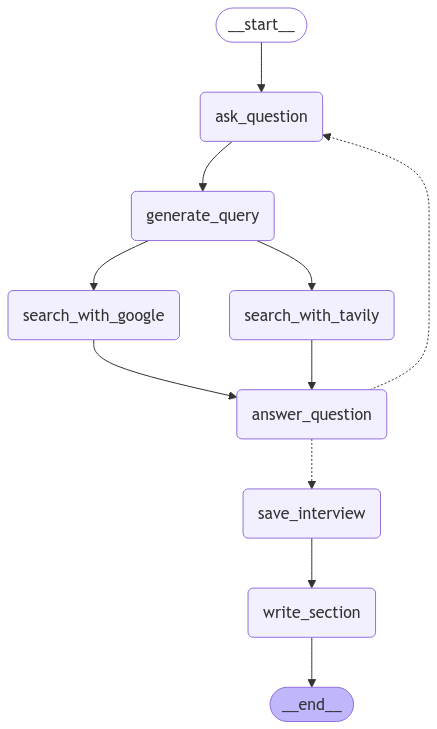

In [29]:
# Add nodes and edges 
interview_builder = StateGraph(InterviewState)
interview_builder.add_node("ask_question", generate_question)
interview_builder.add_node("generate_query", generate_search_query)
interview_builder.add_node("search_with_tavily", search_with_tavily)
interview_builder.add_node("search_with_google", search_with_google)
interview_builder.add_node("answer_question", generate_answer)
interview_builder.add_node("save_interview", save_interview)
interview_builder.add_node("write_section", write_section)

# Flow
interview_builder.add_edge(START, "ask_question")
interview_builder.add_edge("ask_question", "generate_query")
interview_builder.add_edge("generate_query", "search_with_tavily")
interview_builder.add_edge("generate_query", "search_with_google")
interview_builder.add_edge("search_with_tavily", "answer_question")
interview_builder.add_edge("search_with_google", "answer_question")
interview_builder.add_conditional_edges("answer_question", route_messages,['ask_question','save_interview'])
interview_builder.add_edge("save_interview", "write_section")
interview_builder.add_edge("write_section", END)

# Interview 
memory = MemorySaver()
interview_graph = interview_builder.compile(checkpointer=memory).with_config(run_name="Conduct Interviews")

# View
display(Image(interview_graph.get_graph().draw_mermaid_png()))

In [30]:
analyzer = analysts[1]
analyzer, topic

(Analyst(affiliation='AI Startup Founder', name='Alex Chen', role='Entrepreneur', description='Interested in the potential of LangGraph to drive innovation and growth in the AI industry'),
 'The benefits of adopting LangGraph as an agent framework')

In [31]:
from IPython.display import Markdown
messages = [HumanMessage(f"So you said you were writing an article on {topic}?")]
thread = {"configurable": {"thread_id": CONF_ID}}
interview = interview_graph.invoke({"analyst": analysts[1], "messages": messages, "max_num_turns": 2}, thread)
Markdown(interview['sections'][0])

THE SEARCH QUERY IS: LangGraph agent framework benefits for AI startup development and growth
THE SEARCH QUERY IS: benefits of adopting LangGraph as an agent framework for AI startups and its potential to drive innovation and growth


## Unlocking Innovation with LangGraph in AI Development
### Summary
The potential of LangGraph to drive innovation and growth in the AI industry is vast, with its ability to facilitate the development and deployment of AI agents that can understand and generate human language effectively. According to various sources, LangGraph provides tools and structures that streamline the process of natural language understanding and generation, enabling developers to create powerful AI agents [1], [2]. What's novel about LangGraph is its composable framework, which allows for the building of complex production-ready features with LLMs [3]. Interestingly, some developers have reported success in deploying LangGraph AI agents in as little as 5 minutes for free [4]. The insights gathered from these sources highlight the growing adoption of open-source agentic frameworks like LangGraph in AI development. Here are some key sources used in this summary:
1. LangGraph in production discussions on Reddit [5]
2. Comparisons of LangGraph with other AI agent frameworksrets [6]
3. Official LangGraph documentation [7]
4. Tutorials on deploying Langodon AI agents [8]
5. Articles on the benefits of open-source agentic frameworks [9]
6. Research on the technical advantages of adopting LangGraph [10]

### Sources
[1] https://www.reddit.com/r/LangChain/comments/1dl47vz/langgraph_in_production/ 
[2] https://www.rapidinnovation.io/post/ai-agents-in-langgraph 
[3] https://www.langchain.com/langgraph 
[4] https://ai.gopubby.com/deploy-a-langgraph-ai-agent-in-5-minutes-for-free-part-1-0521d52140b6 
[5] https://www.reddit.com/r/LangChain/comments/1hqufg2/why_isnt_langchainlanggraph_productionready/ 
[6] https://oyelabs.com/langgraph-vs-crewai-vs-openai-swarm-ai-agent-framework/ 
[7] https://www.langchain.com/ 
[8] https://ai.gopubby.com/deploy-a-langgraph-ai-agent-in-5-minutes-for-free-part-1-0521d52140b6 
[9] https://blog.premai.io/open-source-agentic-frameworks-langgraph-vs-crewai-more/ 
[10] https://github.com/langchain-ai/langchain-academy/blob/main/module-4/research-assistant.ipynb